In [1]:
import re
import string
import json
import os
import shutil
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
import sacremoses
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid, NearestNeighbors
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import (
    BernoulliNB,
    CategoricalNB,
    ComplementNB,
    GaussianNB,
    MultinomialNB,
)
from sklearn.svm import LinearSVC, NuSVC, OneClassSVM, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.impute import KNNImputer
# from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import (
    OneHotEncoder,
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    minmax_scale,
    Normalizer,
    normalize,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import dask
import dask.dataframe as dd

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black



<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn.vectorizers import FreqVectorizer, Doc2Vectorizer, AverageVectorizer
from tools.sklearn import selection

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "description",
        "feature",
        "title",
        "brand",
        "sub_cat",
        "main_cat",
    ],
)
display(df.head())
df.shape

,description,feature,title,brand,sub_cat,main_cat
asin,,,,,,
1441072241,after rising in the appalachian mountains of v...,None,come tell me how you lived: native american hi...,enter the arena,"[books, history, americas, native american]",all beauty
162021444X,peach reynolds has always been fascinated with...,None,kaleidoscope 2016 wall calendar by calendar ink,lavinso,"[office products, office & school supplies, wa...",all beauty
6090113980,note : we cannot guarantee 100% that you will ...,None,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",all beauty
6546546450,loud 'n clear personal sound amplifier allows ...,None,loud 'n clear™ personal sound amplifier,idea village,None,all beauty
7250468162,no7 stay perfect foundation now stays perfect ...,None,no7 stay perfect foundation cool vanilla by no7,no7,None,all beauty


(6217338, 6)

<IPython.core.display.Javascript object>

In [4]:
df["sub_cat_join"] = df.loc[:, "sub_cat"].str.join(", ")
df.head()

,description,feature,title,brand,sub_cat,main_cat,sub_cat_join
asin,,,,,,,
1441072241,after rising in the appalachian mountains of v...,None,come tell me how you lived: native american hi...,enter the arena,"[books, history, americas, native american]",all beauty,"books, history, americas, native american"
162021444X,peach reynolds has always been fascinated with...,None,kaleidoscope 2016 wall calendar by calendar ink,lavinso,"[office products, office & school supplies, wa...",all beauty,"office products, office & school supplies, wal..."
6090113980,note : we cannot guarantee 100% that you will ...,None,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",all beauty,"home & kitchen, home dcor, area rugs, runners ..."
6546546450,loud 'n clear personal sound amplifier allows ...,None,loud 'n clear™ personal sound amplifier,idea village,None,all beauty,None
7250468162,no7 stay perfect foundation now stays perfect ...,None,no7 stay perfect foundation cool vanilla by no7,no7,None,all beauty,None


<IPython.core.display.Javascript object>

In [5]:
df["brand"] = lang.force_ascii(df.loc[:, "brand"])
df["brand"] = lang.strip_non_word(df.loc[:, "brand"])
df["brand"] = lang.strip_extra_space(df.loc[:, "brand"])
df["brand"] = df.loc[:, "brand"].str.replace("\s+", "_", regex=True)
df = df.loc[df.brand != ""]
df.head()

,description,feature,title,brand,sub_cat,main_cat,sub_cat_join
asin,,,,,,,
1441072241,after rising in the appalachian mountains of v...,None,come tell me how you lived: native american hi...,enter_the_arena,"[books, history, americas, native american]",all beauty,"books, history, americas, native american"
162021444X,peach reynolds has always been fascinated with...,None,kaleidoscope 2016 wall calendar by calendar ink,lavinso,"[office products, office & school supplies, wa...",all beauty,"office products, office & school supplies, wal..."
6090113980,note : we cannot guarantee 100% that you will ...,None,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",all beauty,"home & kitchen, home dcor, area rugs, runners ..."
6546546450,loud 'n clear personal sound amplifier allows ...,None,loud 'n clear™ personal sound amplifier,idea_village,None,all beauty,None
7250468162,no7 stay perfect foundation now stays perfect ...,None,no7 stay perfect foundation cool vanilla by no7,no7,None,all beauty,None


<IPython.core.display.Javascript object>

In [6]:
cleaning.info(df.drop(columns="sub_cat"))

,null,null_%,uniq,uniq_%,dup,dup_%
feature,2155249,34.67,3415364,54.93,227280,3.66
sub_cat_join,294648,4.74,404031,6.50,227280,3.66
description,0,0.00,5989982,96.34,227280,3.66
title,0,0.00,5926087,95.32,227280,3.66
brand,0,0.00,1118246,17.99,227280,3.66
main_cat,0,0.00,31,0.00,227280,3.66


<IPython.core.display.Javascript object>

In [7]:
df = df.drop_duplicates(subset=utils.hashable_cols(df))
df.shape

(5989982, 7)

<IPython.core.display.Javascript object>

In [8]:
df = df.fillna({"feature": "", "sub_cat_join": ""})
df.isna().sum()

description          0
feature              0
title                0
brand                0
sub_cat         287256
main_cat             0
sub_cat_join         0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
df.brand.value_counts().head(15)

generic                19733
uxcell                 17700
disney                 14825
nike                   14152
3drose                 13978
adidas                 13658
sony                    7914
various_artists         7778
yu_gi_oh                7409
magic_the_gathering     6806
invicta                 6548
samsung                 6512
reebok                  5980
hp                      5774
amscan                  5540
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
df = df.loc[~df.brand.str.startswith("various")]
df = utils.prune_categories(df, "brand", cut=1e-5)
display(df.shape)
df.brand.value_counts()

                                       Dropped
00                                5.019820e-07
000                               3.346547e-07
00000000000                       1.673273e-07
0001                              5.019820e-07
00061j                            1.673273e-07
...                                        ...
zzz_qinglonglin                   1.673273e-07
zzz_sleep_products                3.346547e-07
zzzband                           3.346547e-07
zzzrt_traders                     2.007928e-06
zzzzzzc_f_enterprises_do_not_use  1.673273e-07

[1104851 rows x 1 columns]


(2843277, 7)

generic          19733
uxcell           17700
disney           14825
nike             14152
3drose           13978
                 ...  
ugee                60
playfirst           60
magnolia_lane       60
gabor               60
tomahawk            60
Name: brand, Length: 13198, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
text_schema = "{title}. {description}. {feature}. {brand}, {sub_cat_join}."


def construct_text(item, schema=text_schema):
    return schema.format(**item)


construct_text(df.iloc[0])

'prayer rug carpet mat gebetsteppich islamic muslim musallah eid abaya salat 365. note : we cannot guarantee 100% that you will receive the same color, factories usually change their designs very often ( you will receive same or similar designs as shown pictures ) item description : prayer rug carpet mat gebetsteppich islamic muslim musallah eid abaya salat can be used anywhere any time !! made of very light 100% durable materials very beautiful printed designs this is one gorgeous piece! note : we cannot guarantee 100% that you will receive the same design as shown pictures , but for sure you will receive the same color, factories usually change their designs very often ( you will receive same or similar designs as shown pictures ) a great find for the egyptian treasure collector condition: 100% new quantity : 1pcs color: red color weight (approx.) : 380 gm = ( 13.40 oz ) material: 100% polyester size (approx.) : -length: 45.5" inch = 115.5 cm -width : 27.5" inch = 70 cm. . bonballoon

<IPython.core.display.Javascript object>

In [12]:
text = df.apply(construct_text, axis=1)
text.name = "text"
text

asin
6090113980    prayer rug carpet mat gebetsteppich islamic mu...
8867326759    moleskine payne's grey card wallet (moleskine ...
9623402791    hello kitty taupe embossed face wallet loungef...
9742121109    estee lauder resilience lift night firming/scu...
B00004TUBN    better living the dispenser classic chrome iii...
                                    ...                        
B01HJ149LI    god eater resurrection - ps vita [digital code...
B01HJ14FDA    jojo eyes of heaven complete bundle - ps4 [dig...
B01HJ14OT0    the technomancer - ps4 [digital code]. the tec...
B01HJ14TTA    lego star wars: the force awakens season pass ...
B01HJ1521Y    lego star wars: the force awakens - ps vita [d...
Name: text, Length: 2843277, dtype: object

<IPython.core.display.Javascript object>

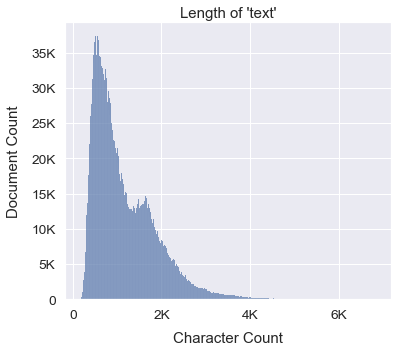

<IPython.core.display.Javascript object>

In [13]:
fig = lang.length_dist(text)

In [14]:
text.loc[text.str.len().idxmax()]

'mitutoyo steel rectangular gage block, asme grade as-1, metric. the mitutoyo grade as-1 rectangular gage block is made of steel, has its nominal length engraved in metric [millimeter (mm)], and is supplied with a mitutoyo inspection certificate that states that the block meets american society of mechanical engineers (asme) b89.1.9-2002 grade standard for flatness, length, parallelism, and surface finish. the inspection certificate specifies the deviation of the individual block from its nominal length. gage blocks are commonly used to calibrate fixtures and precision instruments in workshop, inspection, and dimensional metrology applications, to inspect tools such as mounting tools, cutters, fixtures, and mechanical parts, and in the gage manufacturing process itself. this grade as-1 gage block is commonly used for workshop and inspection applications to calibrate fixtures and precision instruments, to inspect a variety of tools such as mounting tools, cutters, fixtures, and mechanic

<IPython.core.display.Javascript object>

        len_text
min          162
median       941
max        3,504


           n_trimmed  pct_trimmed
text          28,395            1
total_obs     28,395            1


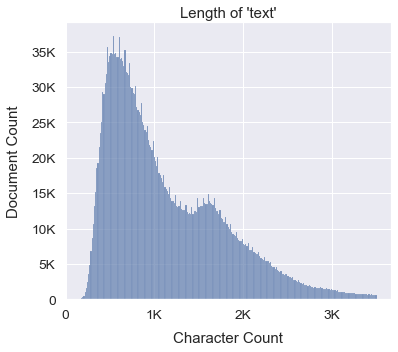

<IPython.core.display.Javascript object>

In [15]:
text = lang.trim_length_outliers(text, q_upper=0.99)
fig = lang.length_dist(text)

In [16]:
text.loc[text.str.len().idxmax()]

"hewlett packard jornada 568 pocket pc. hewlett packard's 560 line of jornada pdas includes the 32 mb jornada 565 and our 64 mb 568, members for the first batch of pocket pcs to ship with microsoft's new pocket pc 2002 operating system. on the surface, the pocket pc 2002 os looks much the same as the old os. but there are a variety of enhancements to the stable of applications (like word and excel), new software such as msn messenger, added security and antivirus protection, and improved handwriting recognition. the jornada 568 features a compactflash type 1 slot, so you can add more cf memory as well as hook up cf peripherals, such as modems or network cards. you'll probably want to expand on the memory front--64 mb is decent for a pocket pc, but you always want more to play back any video or audio files. and compactflash memory prices have plummeted in recent months, making it an affordable upgrade. the well-designed jornada 568 sits nicely in hand, with a sturdy flip-up cover adding

<IPython.core.display.Javascript object>

In [17]:
if df.columns.intersection(["description", "feature", "sub_cat"]).size:
    df.drop(columns=["description", "feature", "sub_cat_join"], inplace=True)
df = pd.merge(text, df, left_index=True, right_index=True, how="left")
df.head()

,text,title,brand,sub_cat,main_cat
asin,,,,,
6090113980,prayer rug carpet mat gebetsteppich islamic mu...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",all beauty
8867326759,moleskine payne's grey card wallet (moleskine ...,moleskine payne's grey card wallet (moleskine ...,sunatoria,None,all beauty
9623402791,hello kitty taupe embossed face wallet loungef...,hello kitty taupe embossed face wallet loungef...,hello_kitty,None,all beauty
9742121109,estee lauder resilience lift night firming/scu...,estee lauder resilience lift night firming/scu...,chom,None,all beauty
B00004TUBN,better living the dispenser classic chrome iii...,better living the dispenser classic chrome iii,classic,"[home & kitchen, bathroom accessories, holders...",all beauty


<IPython.core.display.Javascript object>

In [18]:
df.main_cat.value_counts().to_frame().style.bar()

,main_cat
amazon home,545647
amazon fashion,418676
sports & outdoors,286133
toys & games,239019
automotive,225929
tools & home improvement,217844
cell phones & accessories,114479
grocery,87873
computers,86755
office products,84458


<IPython.core.display.Javascript object>

In [23]:
path = os.path.normpath("data/model_text")
if os.path.isdir(path):
    shutil.rmtree(path)

df.to_parquet(
    path,
    engine="pyarrow",
    index=True,
    partition_cols=["main_cat"],
)

<IPython.core.display.Javascript object>

In [19]:
df = pd.read_parquet("data/model_text", engine="pyarrow")
display(df.head())
df.shape

,text,title,brand,sub_cat,main_cat
asin,,,,,
6090113980,prayer rug carpet mat gebetsteppich islamic mu...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",all beauty
8867326759,moleskine payne's grey card wallet (moleskine ...,moleskine payne's grey card wallet (moleskine ...,sunatoria,None,all beauty
9623402791,hello kitty taupe embossed face wallet loungef...,hello kitty taupe embossed face wallet loungef...,hello_kitty,None,all beauty
9742121109,estee lauder resilience lift night firming/scu...,estee lauder resilience lift night firming/scu...,chom,None,all beauty
B00004TUBN,better living the dispenser classic chrome iii...,better living the dispenser classic chrome iii,classic,"[home & kitchen, bathroom accessories, holders...",all beauty


(2814882, 5)

<IPython.core.display.Javascript object>

In [20]:
samp = utils.stratified_sample(df, "main_cat", 1 * 10 ** 6, random_state=31526)
samp

,text,title,brand,sub_cat,main_cat
asin,,,,,
B00KCOYPFK,boss ar2000m 2000w mono car amplifier + remote...,boss ar2000m 2000w mono car amplifier + remote...,boss_audio_systems,"[electronics, car & vehicle electronics, car e...",car electronics
B006ZGWB0K,"glade expressions fragrance mist starter, pine...","glade expressions fragrance mist starter, pine...",glade,"[automotive, interior accessories, air freshen...",health & personal care
B00JAJBIIA,genuine vintage leather case for iphone 5s 5 b...,genuine vintage leather case for iphone 5s 5 b...,shop_leather,"[cell phones & accessories, cases, holsters & ...",cell phones & accessories
B00B1ODFNS,"gs1000 full hd 1080p 1.5"" lcd display 5mp car ...","gs1000 full hd 1080p 1.5"" lcd display 5mp car ...",generic,"[electronics, gps, finders & accessories, vehi...",gps & navigation
0062484397,and then there were none facsimile edition. th...,and then there were none facsimile edition,agatha_christie,"[books, mystery, thriller & suspense, thriller...",books
...,...,...,...,...,...
B01BC4292O,ranger tda49425 tim holtz empty distress tin. ...,ranger tda49425 tim holtz empty distress tin,ranger,"[arts, crafts & sewing, painting, drawing & ar...","arts, crafts & sewing"
B005IR00SW,riddell pac-12 pocket size conference helmet s...,riddell pac-12 pocket size conference helmet set,riddell,"[sports & outdoors, fan shop, sports souvenirs...",sports & outdoors
B00LX7LV1G,asus m11ad-us013o desktop (3.2 ghz intel i7-47...,asus m11ad-us013o desktop (3.2 ghz intel i7-47...,asus,"[electronics, computers & accessories, compute...",computers


<IPython.core.display.Javascript object>

In [21]:
samp.main_cat.value_counts().to_frame().style.bar()

,main_cat
amazon home,70268
amazon fashion,68631
sports & outdoors,65902
toys & games,64780
automotive,63850
tools & home improvement,63407
cell phones & accessories,54763
grocery,50388
computers,50178
office products,49801


<IPython.core.display.Javascript object>


# Modeling
## Train-Test Split

In [22]:
X = samp.loc[:, "text"]
y = samp.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750000,), (250000,), (750000,), (250000,))

<IPython.core.display.Javascript object>

In [23]:
fv = FreqVectorizer(
    lowercase=False,
    decode_html_entities=False,
)

fv

FreqVectorizer(decode_html_entities=False, lowercase=False)

<IPython.core.display.Javascript object>

In [24]:
pipe = Pipeline(
    [
        ("vec", fv),
        ("cls", "passthrough"),
    ],
    memory="pipeline_cache",
)
pipe

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False)),
                ('cls', 'passthrough')])

<IPython.core.display.Javascript object>

In [25]:
def plot_confusion_matrix(
    estimator, X_test, y_test, xticks_rotation="vertical", **kwargs
):
    ax = plotting.confusion_matrix(
        estimator,
        X_test,
        y_test,
        xticks_rotation=xticks_rotation,
        **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    return ax

<IPython.core.display.Javascript object>

In [26]:
pipe.fit_transform(X_train, y_train)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

# Baseline SVM

In [27]:
sgd = SGDClassifier(loss="hinge", class_weight="balanced", n_jobs=-1)

pipe.set_params(cls=sgd)

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(decode_html_entities=False, lowercase=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))])

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.87, Balanced Accuracy: 0.85'}, xlabel='Predicted label', ylabel='True label'>

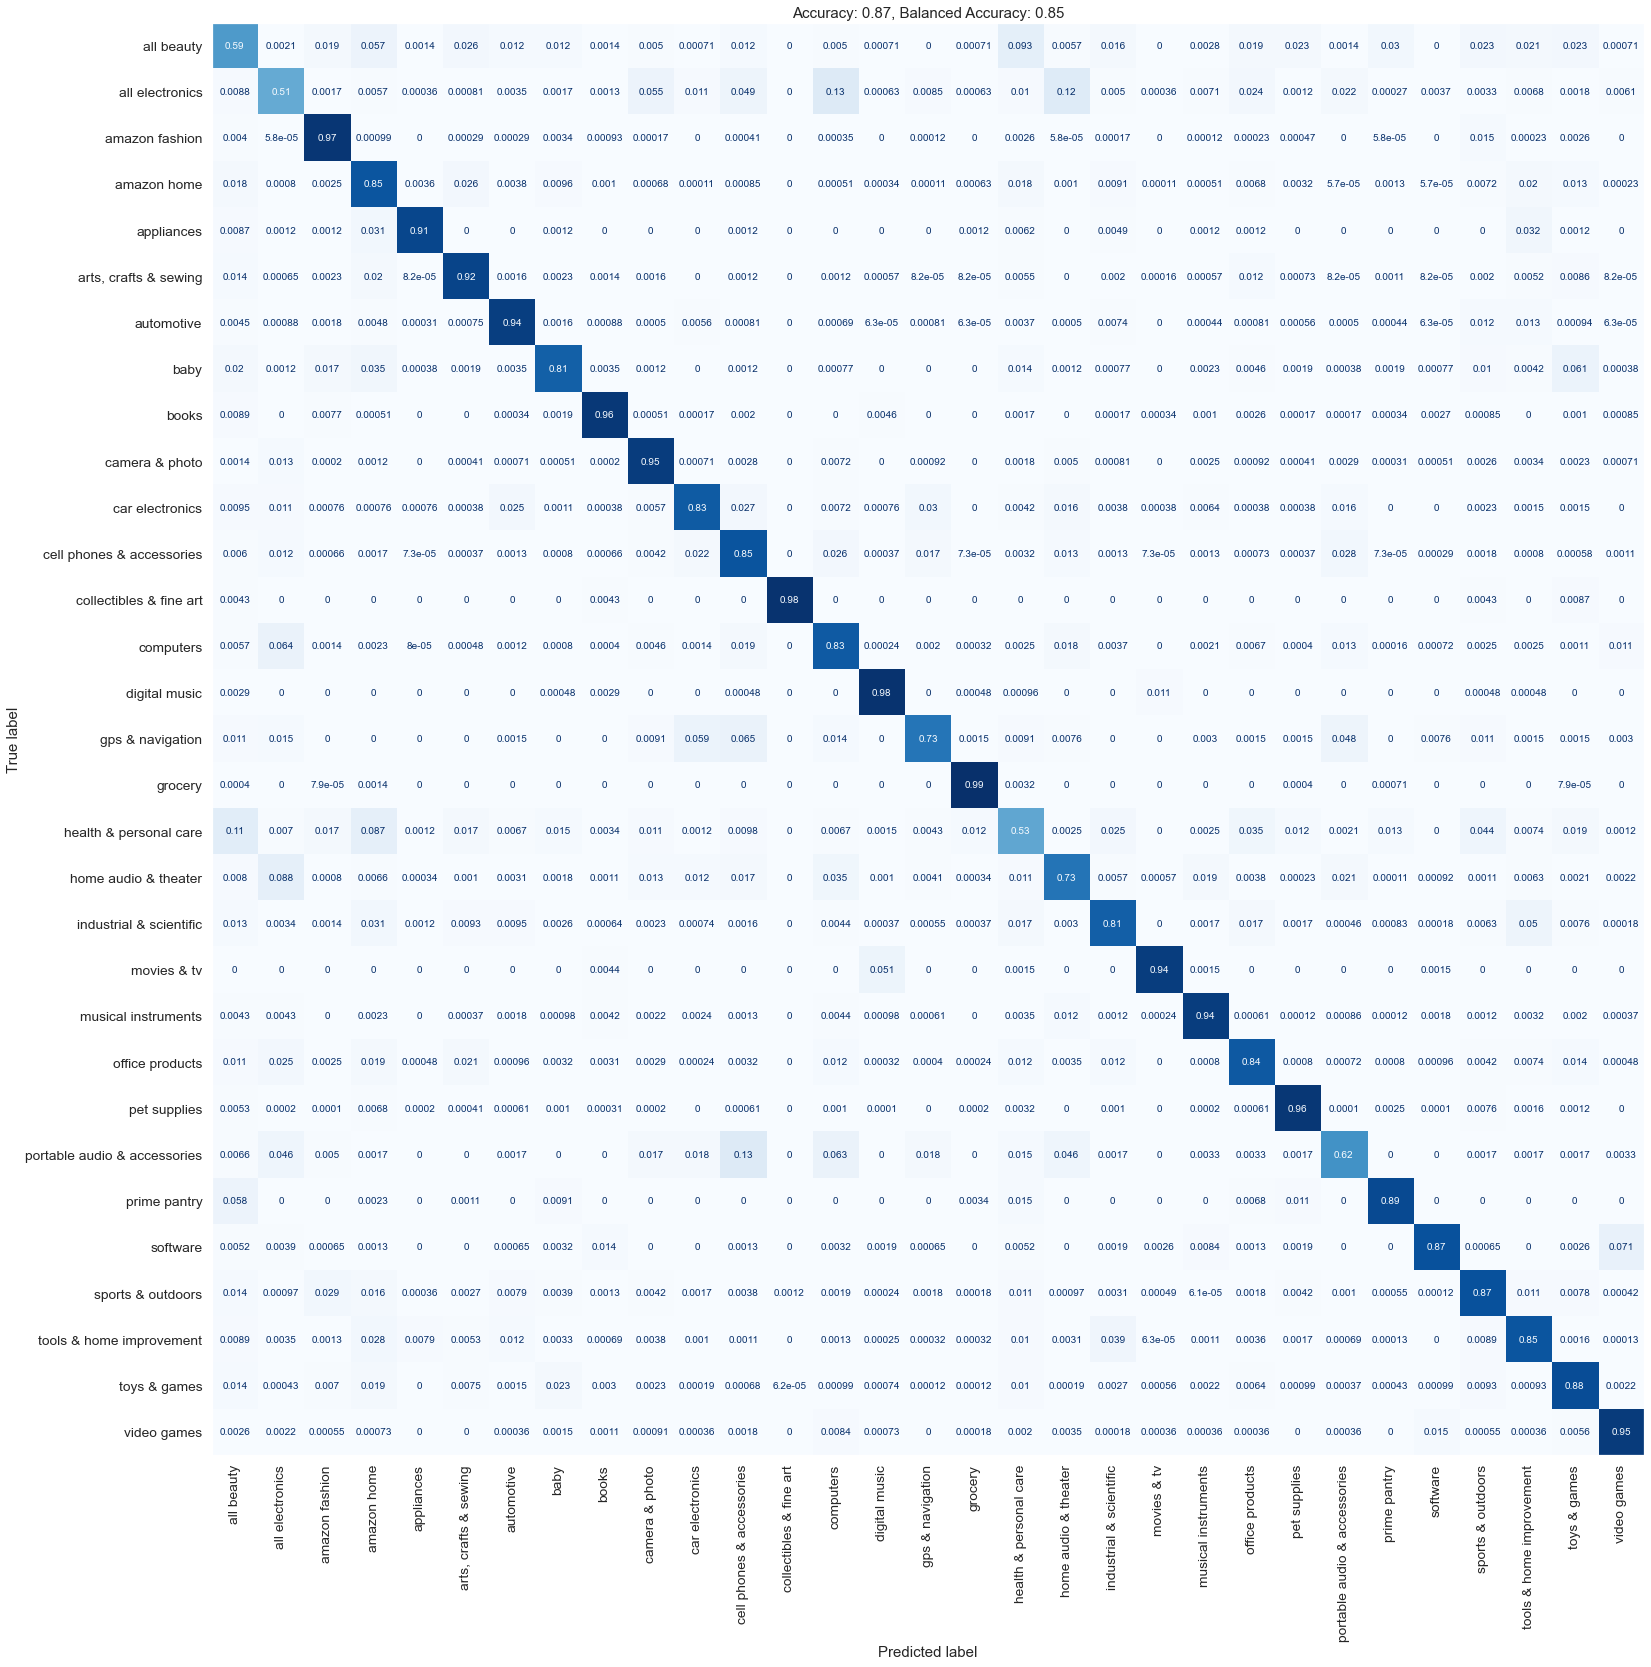

<IPython.core.display.Javascript object>

In [15]:
pipe.fit(X_train, y_train)
plot_confusion_matrix(pipe, X_test, y_test)

# SGD Classifier Selection

In [7]:
sgd_grid = {
    "cls__loss": [
        "hinge",
        "log",
        "modified_huber",
        "squared_hinge",
        "perceptron",
    ],
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}
selection.space_size(sgd_grid)

n_params      4
n_combos     60
n_folds       5
n_fits      300
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
if RUN_SWEEPS:
    gs = selection.sweep(
        clone(pipe).set_params(cls__n_jobs=None),
        sgd_grid,
        X=X_train,
        y=y_train,
        dst="sweeps/sgd_loss",
        kind="grid",
        n_jobs=-1,
    )
else:
    gs = selection.load("sweeps/sgd_loss")

<IPython.core.display.Javascript object>

In [12]:
cv_results = selection.prune_cv(gs.cv_results_)
cv_results.head(10)

,loss,binary,norm,use_idf,params,mean_fit_time,mean_score,rank_score
0,log,True,None,False,"{'cls__loss': 'log', 'vec__binary': True, 'vec...",37.484401,0.85136,1
1,modified_huber,True,l2,True,"{'cls__loss': 'modified_huber', 'vec__binary':...",31.586601,0.85131,2
2,hinge,True,None,False,"{'cls__loss': 'hinge', 'vec__binary': True, 'v...",37.195597,0.84639,3
3,modified_huber,False,l2,True,"{'cls__loss': 'modified_huber', 'vec__binary':...",30.944800,0.84534,4
4,modified_huber,True,l2,False,"{'cls__loss': 'modified_huber', 'vec__binary':...",33.601802,0.84502,5
5,log,False,None,False,"{'cls__loss': 'log', 'vec__binary': False, 've...",49.860798,0.83938,6
6,epsilon_insensitive,True,None,False,"{'cls__loss': 'epsilon_insensitive', 'vec__bin...",144.269692,0.83786,7
7,modified_huber,False,l2,False,"{'cls__loss': 'modified_huber', 'vec__binary':...",30.170999,0.83647,8
8,hinge,True,l2,True,"{'cls__loss': 'hinge', 'vec__binary': True, 'v...",33.162403,0.83412,9
9,log,True,None,True,"{'cls__loss': 'log', 'vec__binary': True, 'vec...",48.169800,0.83339,10


<IPython.core.display.Javascript object>

In [8]:
log_params = cv_results.loc[cv_results.loss == "log", "params"].iloc[0]
hub_params = cv_results.loc[cv_results.loss == "modified_huber", "params"].iloc[0]
hin_params = cv_results.loc[cv_results.loss == "hinge", "params"].iloc[0]
log_params, hub_params, hin_params

NameError: name 'cv_results' is not defined

<IPython.core.display.Javascript object>

# Try Logistic Regression

In [43]:
log_pipe = clone(pipe).set_params(**log_params)
log_pipe

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False)),
                ('cls',
                 SGDClassifier(class_weight='balanced', loss='log',
                               n_jobs=-1))])

<IPython.core.display.Javascript object>

C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py:229: UserWarning: Persisting input arguments took 19.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


<AxesSubplot:title={'center':'Accuracy: 0.86, Balanced Accuracy: 0.85'}, xlabel='Predicted label', ylabel='True label'>

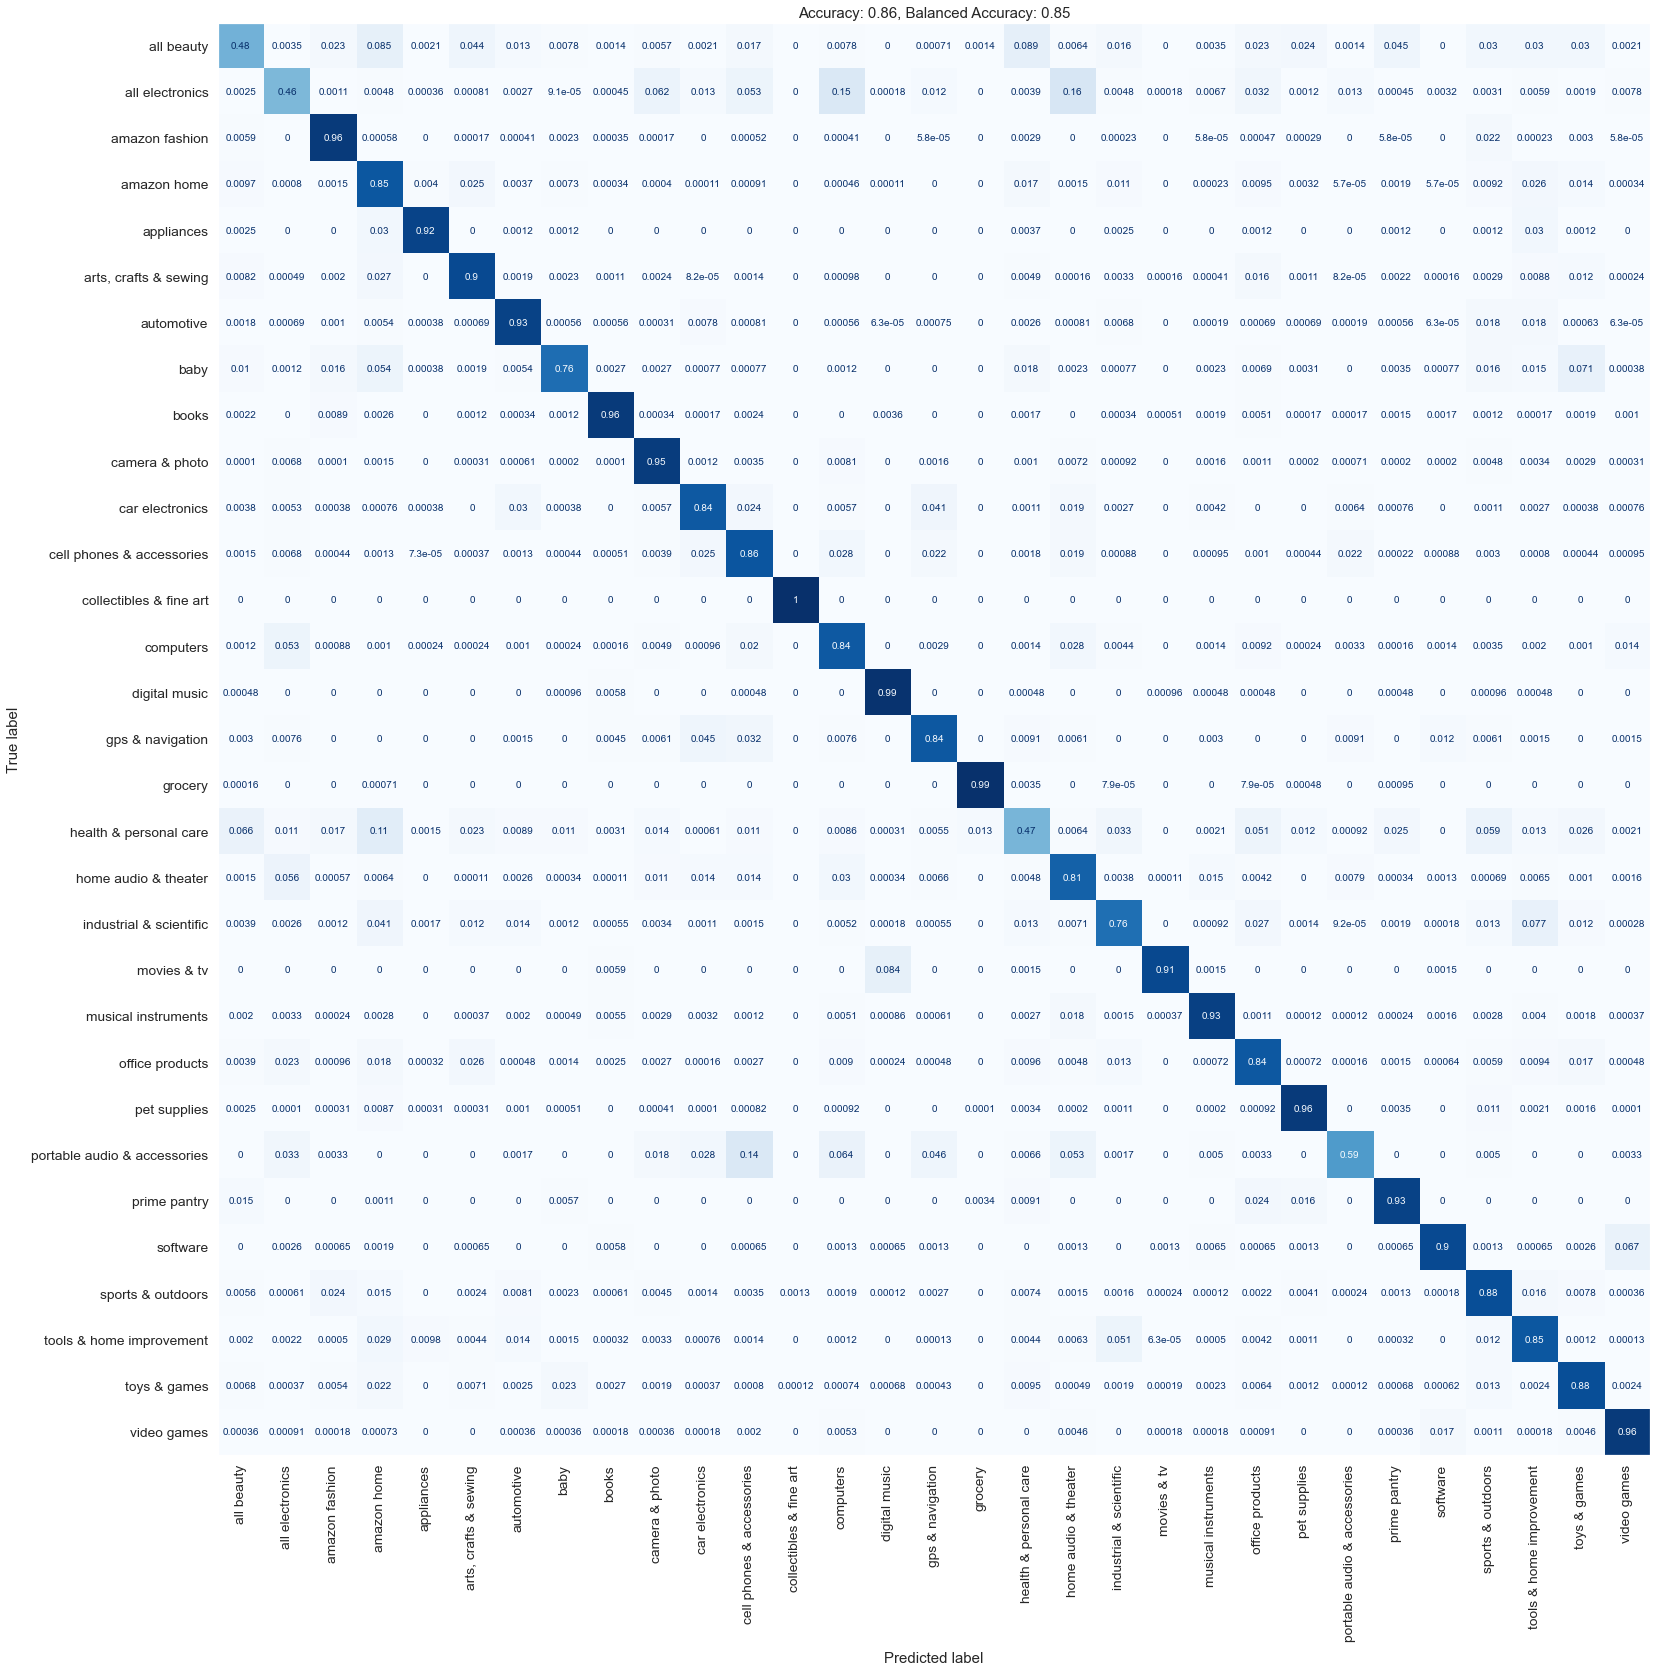

<IPython.core.display.Javascript object>

In [46]:
log_pipe.fit(X_train, y_train)
plot_confusion_matrix(log_pipe, X_test, y_test)

# Try Modified Huber

In [47]:
hub_pipe = clone(pipe).set_params(**hub_params)
hub_pipe

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False, norm='l2', use_idf=True)),
                ('cls',
                 SGDClassifier(class_weight='balanced', loss='modified_huber',
                               n_jobs=-1))])

<IPython.core.display.Javascript object>

C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\imblearn\pipeline.py:229: UserWarning: Persisting input arguments took 19.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


<AxesSubplot:title={'center':'Accuracy: 0.85, Balanced Accuracy: 0.84'}, xlabel='Predicted label', ylabel='True label'>

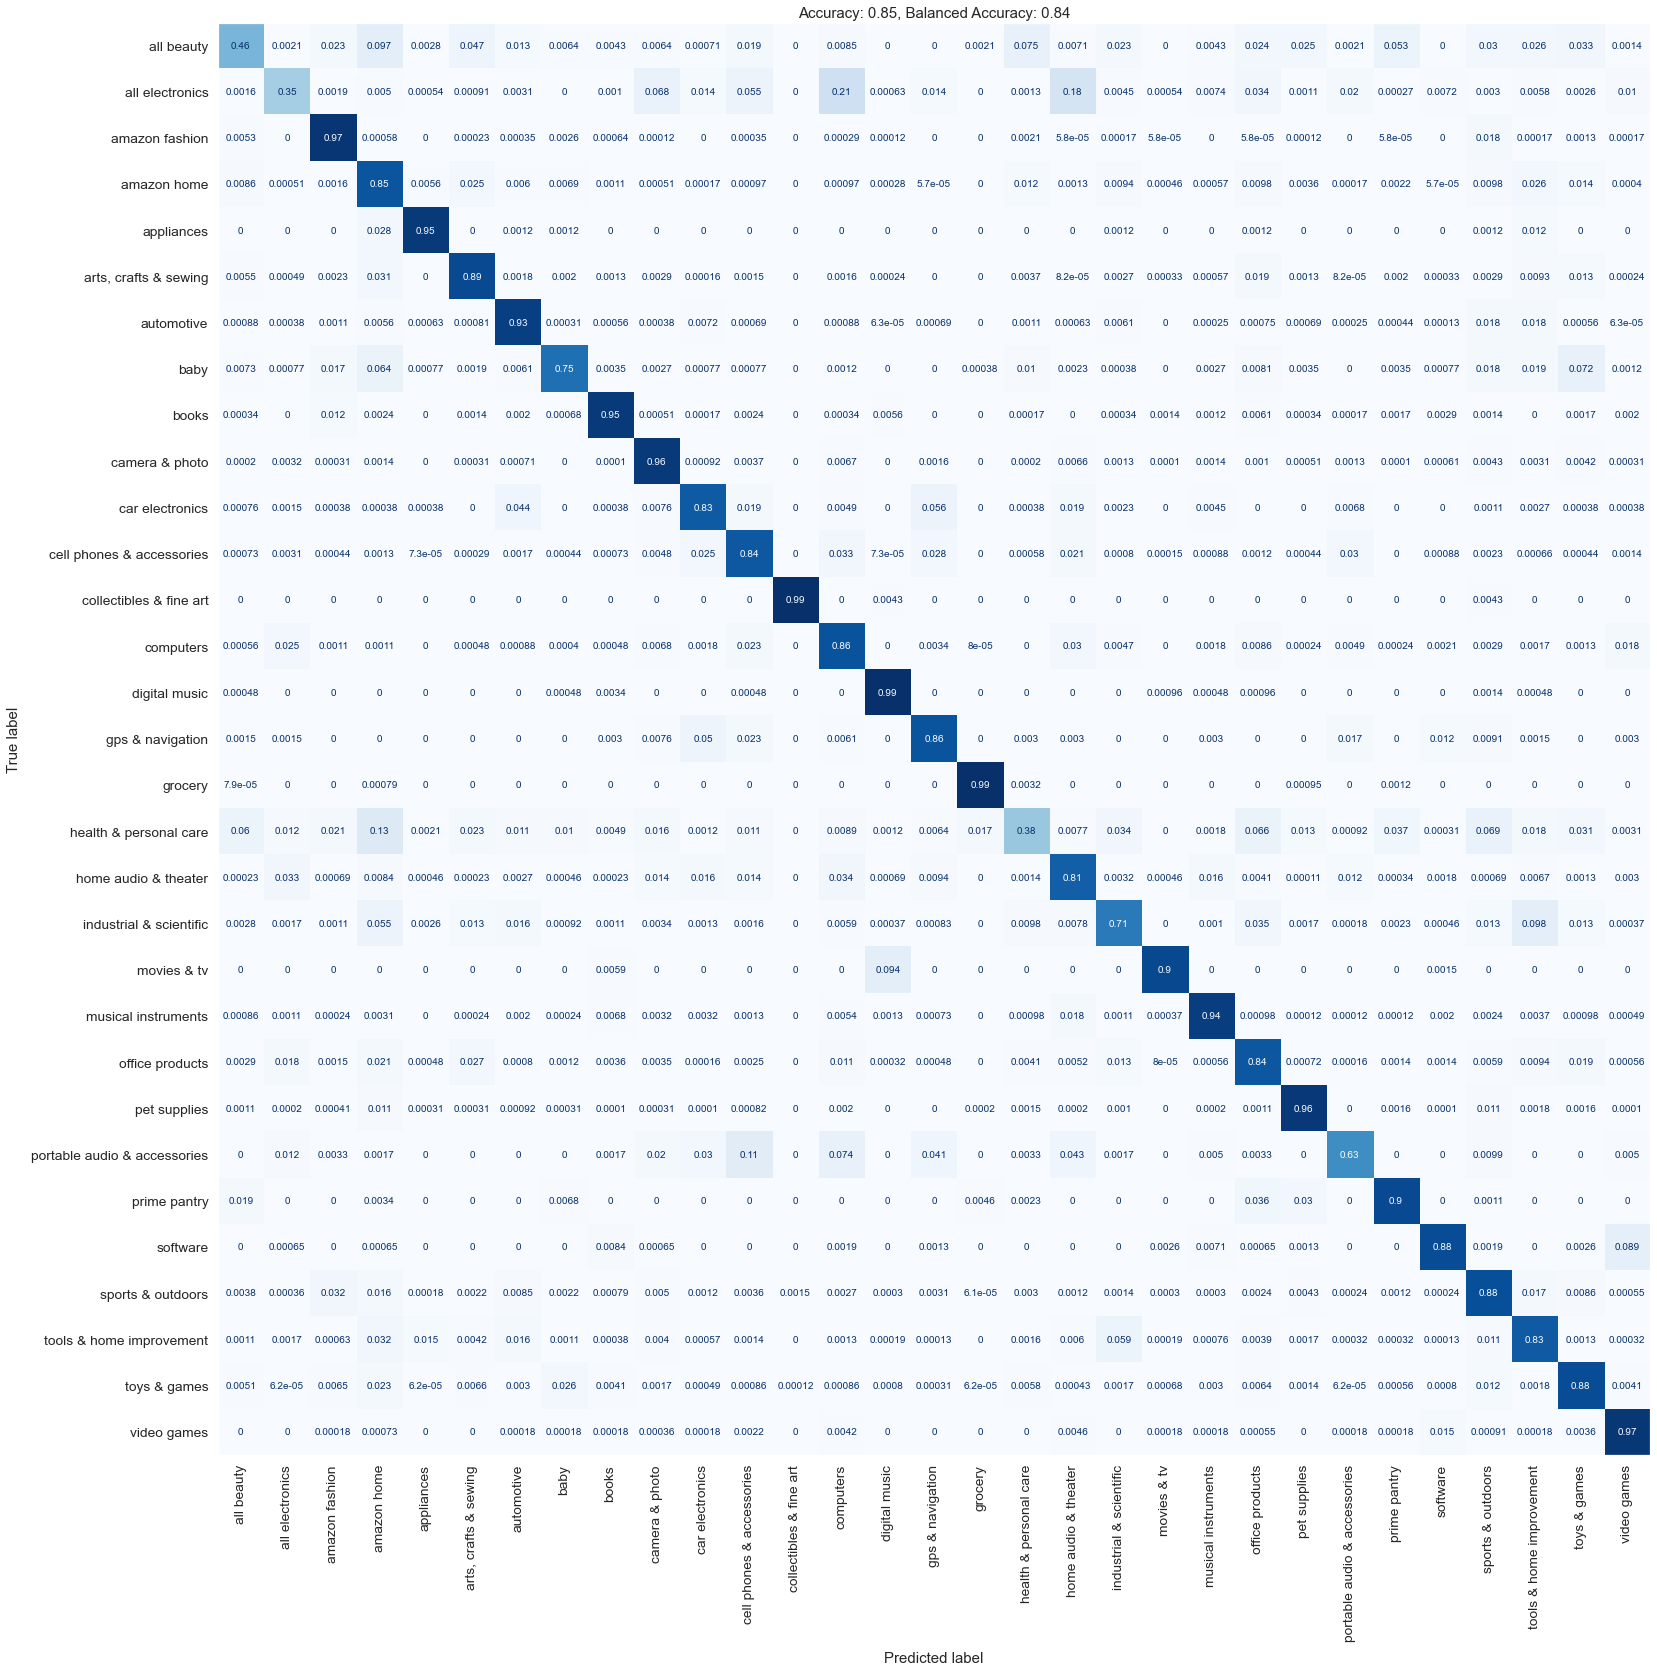

<IPython.core.display.Javascript object>

In [48]:
hub_pipe.fit(X_train, y_train)
plot_confusion_matrix(hub_pipe, X_test, y_test)

# Back to SVM

In [32]:
hin_pipe = clone(pipe).set_params(**hin_params)
hin_pipe

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))])

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Accuracy: 0.87, Balanced Accuracy: 0.86'}, xlabel='Predicted label', ylabel='True label'>

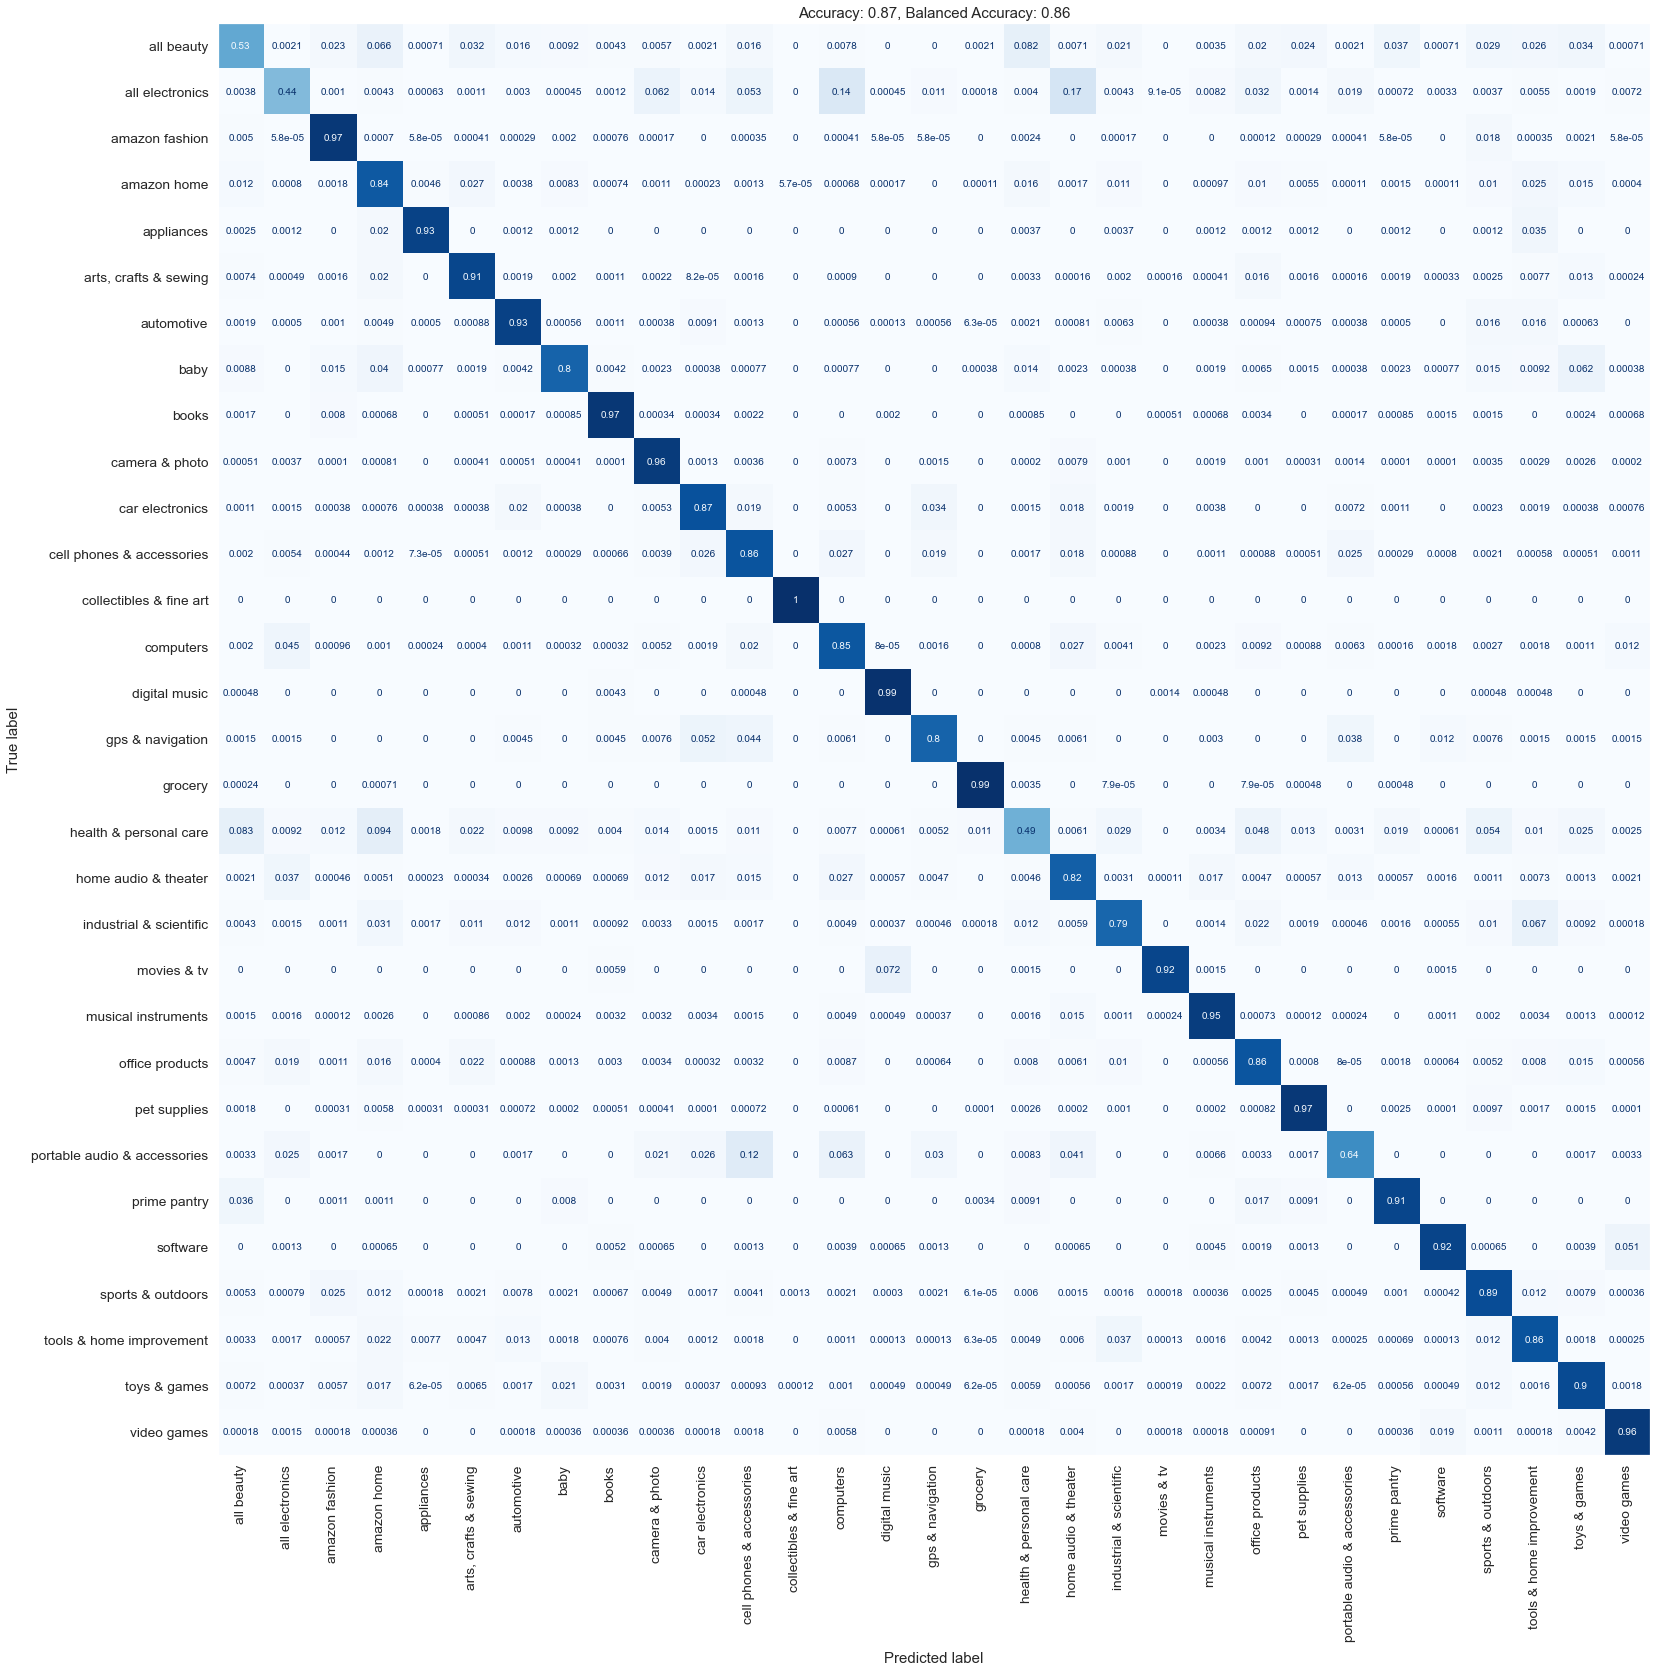

<IPython.core.display.Javascript object>

In [50]:
hin_pipe.fit(X_train, y_train)
plot_confusion_matrix(hin_pipe, X_test, y_test)

In [33]:
pipe = hin_pipe
pipe

Pipeline(memory='pipeline_cache',
         steps=[('vec',
                 FreqVectorizer(binary=True, decode_html_entities=False,
                                lowercase=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))])

<IPython.core.display.Javascript object>